## Intro

When Librosa loads an audio file, there is a default sample rate, which is the number of samples from the mp3's audio signal for one second. Therefore,
to get the length of a song in real time we take the length of the read-in array and divide by the sample rate for that audio sample.

In [18]:
# system packages
import os
import warnings

# usual imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Activation,
    Flatten,
    Conv1D,
    Conv2D,
    BatchNormalization,
    MaxPooling1D,
    MaxPooling2D,
    Dropout,
    Reshape,
    LSTM
)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

## audio tools
import librosa
from torchaudio import info

# my functions and classes
from utilities import (
    view_melspec,
    read_metadata_file,
    Batch_generator,
    id_from_path,
    attach_onehot_encoding,
    mp3_to_mel_path,
    plot_sample
)

# for timing loops
import tqdm

warnings.filterwarnings("ignore", category=UserWarning)

In [19]:
# VERY GLOBAL VARIABLES
audio_dir = "./data/fma_small/"
global_dur = 2.0
global_sr = 22050

The next code chunk is Super handy function that just searches for every mp3 file within the audio directory. 
My audio folder has a bunch of subfolders like '000', '099', etc, and the audio files are
one level further down.

In [20]:
filepaths = librosa.util.files.find_files(audio_dir)

Here is what a typical load looks like. Specifying `sr=None` ensures that the file's default sample-rate is preserved. 
We can also specify the duration with `librosa.load`.

In [21]:
example_source, _ = librosa.load(filepaths[1], sr=global_sr, duration=global_dur)
librosa.get_duration(example_source, sr=global_sr)

2.0

When working with new libraries and data types, I try to get a feel for how the numbers we see come about. For example, this `source` is an array of size $44100$, which comes from multiplying sample rate ($22050$ samples per second) by the duration ($2$ seconds). 

In [22]:
example_source.shape

(44100,)

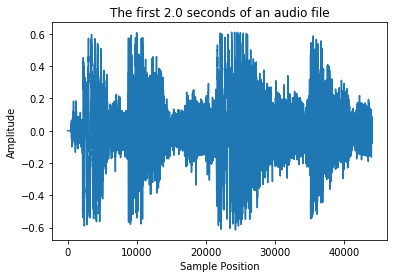

In [23]:
plt.plot(example_source)
plt.title(
    f"The first {librosa.get_duration(example_source, sr=global_sr)} seconds of an audio file"
)
plt.xlabel("Sample Position")
plt.ylabel("Amplitude")
plt.show()

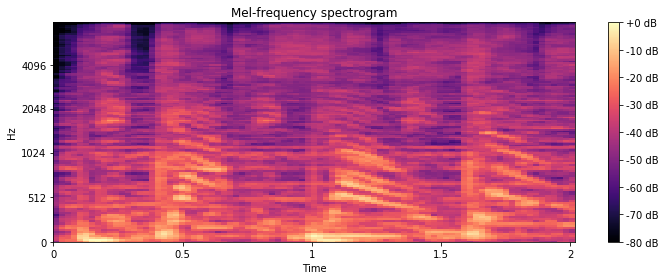

In [24]:
view_melspec(example_source, global_sr)

## How long does a typical load take?

On my linux virtual machine, one second of audio takes between 143 and 214 milliseconds to load one second of audio (down to 129 ms if we don't force a sample rate). 
Multiplying this number by 8 is about how long it will take to load the entire dataset in. I estimate about 15 minutes for the whole FMA Small dataset.

However, on my macbook it takes about 16 ms to load one second of audio in. For five seconds of audio, about 34 ms. This is much faster than the ubuntu machine! This means an estimated 134 seconds, or about two minutes.

This runs a lot faster at 270 microseconds on my ubuntu virtual machine, so it will be a better tool to 
check for integrity. On the macbook it takes about 330 microseconds, a bit slower.


## Check for integrity

This is the only point where I will use `torchaudio` for the `torchaudio.info` method. This method
tries to open the file without loading it into memory. This allows us to check
for corrupted mp3 files. If this leads to a very long list of files, double check the integrity
of your download.

In [25]:
bad_files = []
too_short_duration = 5.0  # seconds
for file in filepaths:
    try:
        info_obj = info(file)[0]

        # Add a file to the bad list if it is shorter than 5 seconds.
        if info_obj.length / (info_obj.rate * info_obj.channels) < 5.0:
            bad_files.append(file)

    except RuntimeError:
        bad_files.append(file)
bad_files

['/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/098/098567.mp3',
 '/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/099/099134.mp3',
 '/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/108/108925.mp3',
 '/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/133/133297.mp3']

## Estimating memory cost

This takes about 1.4 GB of memory to store all song audio.

## Managing Metadata 

The following code takes the giant metadata file coming with the FMA datasets and selects
the track ids and the genres.

In [26]:
metadata_path = os.path.join("data", "fma_metadata", "tracks.csv")

# Read in the metadata and process it. See utilities.py for explanation.
# meta_df = read_metadata_file(metadata_path, filepaths, bad_files)

# meta_df.to_csv("data/fma_metadata/meta_df.csv")
meta_df = pd.read_csv(os.path.join(os.path.split(metadata_path)[0], "meta_df.csv"))

# shuffle the dataset
# meta_df = meta_df.sample(frac=1, random_state=2)

# get a list of the genres
genre_list = list(meta_df.genre.unique())
genre_dict = dict(zip(genre_list, range(len(genre_list))))

In [27]:
## check to make sure each path points to the right file
meta_df["track_id"].equals(meta_df["mp3_path"].apply(lambda x: int(id_from_path(x))))

True

In [28]:
meta_df.head()

,Unnamed: 0,track_id,genre,mp3_path,duration
0,0,2,Hip-Hop,/Users/awray_mac/Documents/data_sci.nosync/fma...,29.988571
1,1,5,Hip-Hop,/Users/awray_mac/Documents/data_sci.nosync/fma...,30.014694
2,2,10,Pop,/Users/awray_mac/Documents/data_sci.nosync/fma...,29.988571
3,3,140,Folk,/Users/awray_mac/Documents/data_sci.nosync/fma...,29.988571
4,4,141,Folk,/Users/awray_mac/Documents/data_sci.nosync/fma...,29.988571


## Duration Analysis

So far, I dropped songs that either (a) did not load, or (b) were shorter than 5 seconds. This only caught 4 songs.

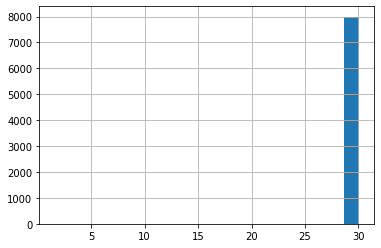

In [29]:
meta_df.duration.hist(bins=20)

In [30]:
meta_df.loc[(meta_df.duration < 28), :]

,Unnamed: 0,track_id,genre,mp3_path,duration
4423,4423,98565,Hip-Hop,/Users/awray_mac/Documents/data_sci.nosync/fma...,1.645714
4424,4425,98569,Hip-Hop,/Users/awray_mac/Documents/data_sci.nosync/fma...,1.567347


Drop these songs that are really short.

In [31]:
meta_df.drop(meta_df.loc[(meta_df.duration < 28), :].index, axis=0, inplace=True)

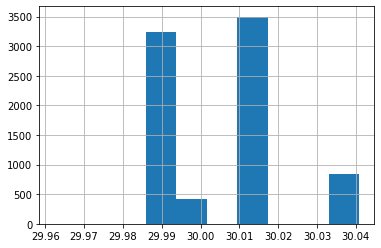

In [32]:
meta_df.duration.hist(bins=10)

## Preprocessing

In [33]:
melspec_dir = os.path.join(".", "data", "fma_small_melspecs")

The next cell will process `.mp3` files into melspectrograms, which are numpy arrays. Numpy arrays are saved as `.npz` files. The next cell will (most likely) be set to a raw cell, so that it does not run when executing the entire notebook.

(Turning a cell from code to raw is like an on-off switch for a cell!)

In order to ensure we get good samples we choose to offset the beginning of a sample (since many songs don't have a lot of audio at the beginning). We take the offset to be a uniform random number in the middle 50% of the song length. 

In [34]:
# If the preprocessing step was not run, this will append the correct paths.
if "mel_path" not in meta_df.columns:
    meta_df["mel_path"] = meta_df["mp3_path"].apply(
        lambda x: mp3_to_mel_path(x, melspec_dir)
    )

In [35]:
# encode genre column
if not set(genre_list).issubset(meta_df.columns):
    meta_df = attach_onehot_encoding(meta_df, "genre")

## Analyzing the preprocessing

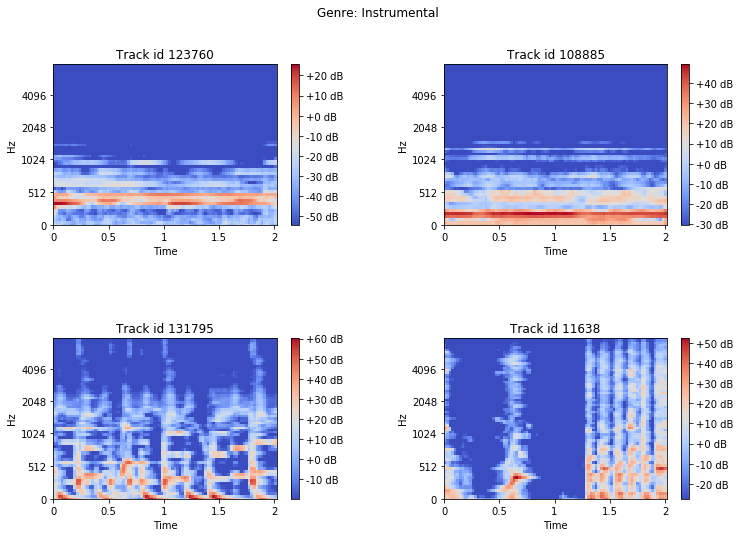

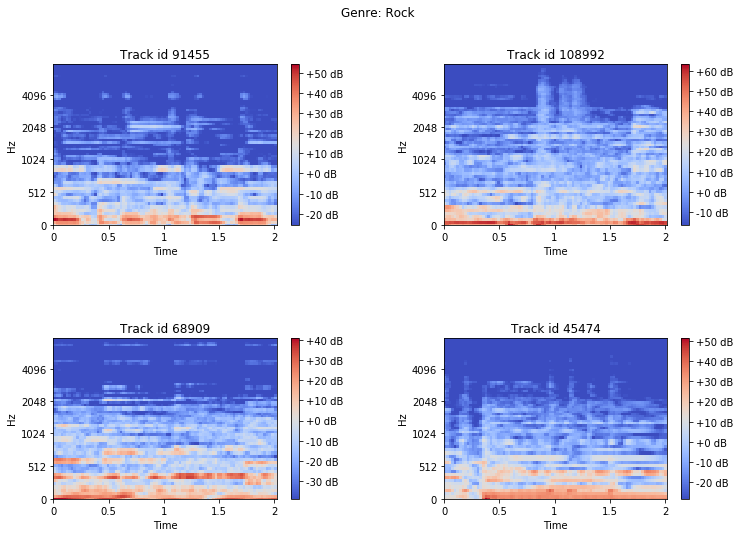

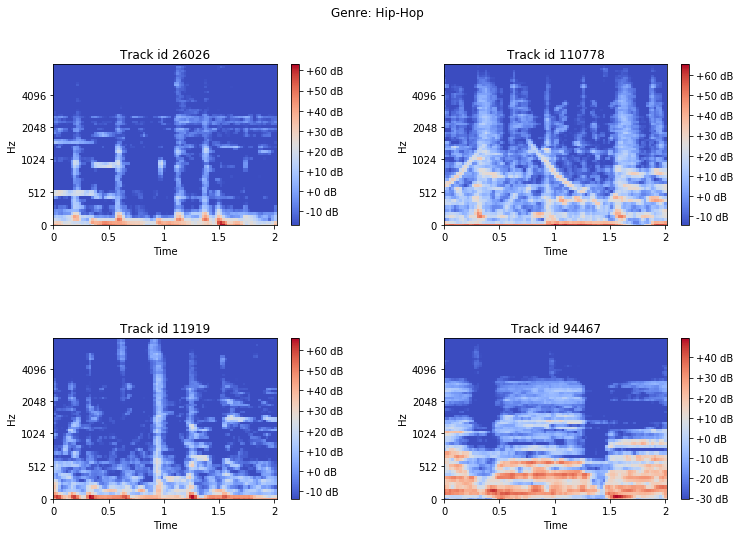

In [36]:
plot_sample("Instrumental", meta_df, nrow=2)
plot_sample("Rock", meta_df, nrow=2)
plot_sample("Hip-Hop", meta_df, nrow=2)

# Models

In [37]:
input_shape = np.load(meta_df['mel_path'].iloc[0])['arr_0'].shape + (1,)

In [80]:
class MyModel:
    """
    Wrapper class around my training, loading, and evaluation.
    """

    def __init__(
        self,
        batch_size,
        model_dir,
        input_shape=input_shape,
        params=None,
        meta_df=meta_df,
        genre_dict=genre_dict,
    ):
        self.batch_size = batch_size
        self.params = params
        self.genre_dict = genre_dict 
        self.model_dir = model_dir
        
        self.model_path = glob.glob(os.path.join(model_dir, '*.h5'))
        ### Currently this will fail if there isn't already a file there.
        
        if self.model_path:
            self.model_path = self.model_path[0]
        else:
            self.model_path = os.path.join(self.model_dir, 'model.h5')
            

        # 60 - 20 - 20 split
        self.train_gen = Batch_generator(
            meta_df.iloc[:4800, :],
            batch_size=self.batch_size,
            genre_dict=self.genre_dict,
        )
        self.valid_gen = Batch_generator(
            meta_df.iloc[4800:6400, :],
            batch_size=self.batch_size,
            genre_dict=self.genre_dict,
        )
        self.test_gen = Batch_generator(
            meta_df.iloc[6400:, :],
            batch_size=self.batch_size,
            genre_dict=self.genre_dict,
        )

        self.input_shape = input_shape

    def attach_model(self, model):
        self.model = model

    def load_model(self):
        """
        Loads the model from the model directory. Alternative to passing 
        a new model.
        """
        if os.path.exists(self.model_path):
            self.model = tf.keras.models.load_model(self.model_path)
        else:
            raise ValueError("File Not Found. Please train model.")

    def fit(self, num_epochs):
        checkpoint_callback = ModelCheckpoint(
            self.model_path,
            monitor="val_accuracy",
            verbose=1,
            save_best_only=True,
            mode="max",
        )
        reducelr_callback = ReduceLROnPlateau(
            monitor="val_accuracy", factor=0.5, patience=5, min_delta=0.01, verbose=1
        )
        early_stop = EarlyStopping(
            monitor="val_accuracy", patience=10, verbose=1, restore_best_weights=True
        )

        callbacks_list = [checkpoint_callback, reducelr_callback, early_stop]

        self.history = self.model.fit_generator(
            generator=self.train_gen,
            epochs=num_epochs,
            verbose=1,
            validation_data=self.valid_gen,
            callbacks=callbacks_list,
        )

    def summary(self):
        return self.model.summary()

    def _compile(self):
        self.model.compile(
            optimizer=Adam(lr=0.001),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

    def evaluate(self, verbose=0, all=False):

        if all:
            print("Training set")
            self.model.evaluate(self.train_gen, verbose=verbose),
            print("Validation set")
            self.model.evaluate(self.valid_gen, verbose=verbose),
            print("Testing set")
            self.model.evaluate(self.test_gen, verbose=verbose)
        else:
            print("Testing set")
            self.model.evaluate(self.test_gen, verbose=verbose)

    def plot_history(self):
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Valid'], loc='upper left')
        plt.show()

        plt.savefig(os.path.join(self.model_dir, 'last_training_acc.png'))
        

        # Plot training & validation loss values
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Valid'], loc='upper left')
        plt.show()
        plt.savefig(os.path.join(self.model_dir, 'last_training_loss.png'))
        
        
    def confusion_matrix(print_labels=True):
        
        y_pred = np.argmax(crnn.model.predict_generator(crnn.valid_gen), axis=1)
        classes = np.argmax(crnn.valid_gen.labels, axis=1)
        
        print(confusion_matrix(classes, y_pred))
    
    def classification_report(self):
        
        y_pred = np.argmax(crnn.model.predict_generator(crnn.valid_gen), axis=1)
        classes = np.argmax(crnn.valid_gen.labels, axis=1)

        print(classification_report(classes, y_pred, target_names=list(self.genre_dict.keys())))

## Logistic Regression

It's worth it to see if we can train a logistic regression model and see how well it does at classifying the genres. 

In [81]:
logreg_path = "models/logreg/"
logistic_reg = MyModel(batch_size=16, model_dir=logreg_path)

In [82]:
logistic_reg.load_model()
logistic_reg.summary()
logistic_reg.evaluate(verbose=1, all=True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 5568)              0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 5568)              22272     
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 44552     
Total params: 66,824
Trainable params: 55,688
Non-trainable params: 11,136
_________________________________________________________________
Training set
300/300 [==============================] - 14s 47ms/step - loss: 1.5201 - accuracy: 0.5054
Validation set
100/100 [==============================] - 4s 43ms/step - loss: 2.5269 - accuracy: 0.2438
Testing set
100/100 [==============================] - 4s 42ms/step - loss: 2.4514 - accuracy: 0.2428


The model learns a little bit (better than random guessing), but it seems to be overfitting.

## Multilayer Perceptron

### Three Layers

In [51]:
def create_mlp(n_layers, n_neurons):
    """
    creates a relu multilayer perceptron with `n_layers` layers. 
    """

    mlp_net = Sequential()
    mlp_net.add(Flatten(input_shape=input_shape, name="Flatten"))
    mlp_net.add(BatchNormalization())

    for i in range(n_layers):
        mlp_net.add(
            Dense(
                n_neurons,
                activation="relu",
                kernel_regularizer=regularizers.l2(0.00001),
                name=("hidden_" + str(i + 1)),
            )
        )

    mlp_net.add(Dense(8, activation="softmax"))

    return mlp_net

In [54]:
mlp_path = 'models/mlp/mlp_3_layers/'
mlp = MyModel(batch_size=16, model_dir=mlp_path)

In [55]:
mlp.load_model()
mlp.summary()
mlp.evaluate(verbose=1, all=True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 5568)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 5568)              22272     
_________________________________________________________________
hidden_1 (Dense)             (None, 22)                122518    
_________________________________________________________________
hidden_2 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_3 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_4 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_5 (Dense)             (None, 22)              

This model also overfits a decent amount. 

### 6 Layers

In [ ]:
mlp_path = 'models/mlp/mlp_6_layers/'
mlp = MyModel(batch_size=16, model_dir=mlp_path)

In [ ]:
mlp_model = create_mlp(n_layers=6, n_neurons = np.prod(input_shape)//250)

mlp.attach_model(mlp_model)
mlp._compile()
mlp.summary()
mlp.fit(num_epochs=50)
mlp.plot_history()

Seems to overfit.

## 2D CNN

We explore how well a traditional convolutional neural net works on this dataset.

In [ ]:
def create_cnn(num_genres=8, num_filters = 20, input_shape=input_shape):
    model = Sequential()
    model.add(
        Conv2D(
            num_filters,
            input_shape=input_shape,
            kernel_size=(4, 4),
            activation="relu",
#             data_format="channels_first"
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 4)))
    model.add(
        Conv2D(
            num_filters,
            kernel_size=(3, 5),
            activation="relu",
            kernel_regularizer=regularizers.l2(0.0001),
#             data_format="channels_first"
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(
        Conv2D(
            num_filters,
            kernel_size=(2, 2),
            activation="relu",
            kernel_regularizer=regularizers.l2(0.0001),
#             data_format="channels_first" 
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(num_genres, activation="softmax"))

    return model

In [ ]:
conv_net_path = 'models/convnet/conv_net.h5'
conv_net = MyModel(batch_size=16, model_filepath = conv_net_path)

In [ ]:
conv_net_model = create_cnn()

conv_net.attach_model(conv_net_model)
conv_net._compile()
conv_net.summary()
conv_net.fit(num_epochs=50)
conv_net.plot_history()

## LSTM

In [ ]:
def create_lstm(num_genres=8, input_shape=input_shape):
    model = Sequential()
    model.add(Reshape( (input_shape[0], input_shape[1]), input_shape=input_shape))
    model.add(LSTM(units=100, return_sequences=True, return_state=False))
    model.add(LSTM(units=num_genres, activation="softmax"))
    return model
    

## CRNN

In [83]:
def create_crnn(
    num_genres=8,
    input_shape=input_shape,
    drop_prob=0.2,
    lstm_count=100,
    n_hidden=64,
    n_layers=4,
    conv_filter_count=64,
):
    model = Sequential()
    model.add(Reshape((input_shape[0], input_shape[1]), input_shape=input_shape))

    # 1D convolutional layers
    for i in range(n_layers):
        model.add(
            Conv1D(
                filters=conv_filter_count,
                kernel_size=4,
                activation="relu",
                kernel_regularizer=regularizers.l2(0.001),
                name="convolution_" + str(i + 1),
            )
        )
        model.add(BatchNormalization(momentum=0.9))
        model.add(MaxPooling1D(2))
        model.add(Dropout(drop_prob))

    # LSTM layer

    model.add(LSTM(lstm_count, return_sequences=False))
    model.add(Dropout(drop_prob))

    # Dense layer
    model.add(Dense(n_hidden, kernel_regularizer=regularizers.l2(0.001), name="dense1"))
    model.add(Dropout(drop_prob))

    # softmax output
    model.add(Dense(num_genres))
    model.add(Activation("softmax", name="output_layer"))

    return model

In [84]:
crnn_path = 'models/crnn/'
crnn = MyModel(batch_size=16, model_dir=crnn_path)

In [86]:
crnn.load_model()

In [87]:
crnn.confusion_matrix()
crnn.classification_report()

[[ 69   2   2  18   8  21  45   0]
 [ 28  16  23  30  24  16  33   0]
 [  8   4  95  12   9   9   4   1]
 [  7   8  44  85  15  28  27   3]
 [  5   5  18  17 126  10  16   0]
 [ 10   1  24   7   7  18  15   0]
 [ 42   5  28  30  10  14  81   0]
 [  6  10 155 142  32  31  39   2]]
               precision    recall  f1-score   support

      Hip-Hop       0.39      0.42      0.41       165
          Pop       0.31      0.09      0.14       170
         Folk       0.24      0.67      0.36       142
 Experimental       0.25      0.39      0.30       217
         Rock       0.55      0.64      0.59       197
International       0.12      0.22      0.16        82
   Electronic       0.31      0.39      0.34       210
 Instrumental       0.33      0.00      0.01       417

     accuracy                           0.31      1600
    macro avg       0.31      0.35      0.29      1600
 weighted avg       0.33      0.31      0.26      1600



Probe early layers in network or end results. See which genres get confused.

Remove bias from sampling by sampling at random times.

Ensemble methods if I get a bunch of okay-ish classifiers. 